In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

import matplotlib.pyplot as plt


In [28]:
BATCH_SIZE = 32


transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transform)

In [29]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Text(0.5, 1.0, 'Label : 5')

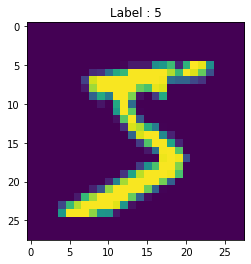

In [30]:
plt.figure()
x, y = trainset[0]
plt.imshow(x[0])
plt.title(f'Label : {y}')

In [31]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26 * 26 * 32, 128)
        self.d2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = x.flatten(start_dim=1)
        
        x = self.d1(x)
        x = F.relu(x)
        
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)

        return out
    

In [47]:
lr = 0.001
num_epoch = 5
model = MyModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(num_epoch):
    running_loss = .0
    train_acc = .0
    for i, (X, y) in enumerate(trainloader):
        logits = model(X)
        loss = criterion(logits, y)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        running_loss += loss.detach().item()
        
        pred_class = torch.argmax(logits, 1).flatten()
        train_acc += (pred_class == y).type(torch.float).mean().item()
    
    print(f"Epoch: {epoch} | Loss: {running_loss/i:.4f} | Train Accuracy: {train_acc/i:.2f}")
        

Epoch: 0 | Loss: 1.6417 | Train Accuracy: 0.82
Epoch: 1 | Loss: 1.5585 | Train Accuracy: 0.90
Epoch: 2 | Loss: 1.4847 | Train Accuracy: 0.98
Epoch: 3 | Loss: 1.4780 | Train Accuracy: 0.99
Epoch: 4 | Loss: 1.4742 | Train Accuracy: 0.99


In [41]:
torch.argmax(out, 1) == y

tensor([False,  True, False, False, False, False, False, False,  True, False,
        False, False,  True, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False])

In [42]:
y.shape

torch.Size([32])

In [50]:
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T
from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



In [ ]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task="node"):
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))
        
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(0.25),
            nn.Linear(hidden_dim, output_dim))
        
        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        if self.task == "node":
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim)
            ))
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)
        
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x  # later visualize
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        if self.task == "graph":
            x = pyg_nn.global_mean_pool(x, batch)
        
        x = self.post_mp(x)
        
        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)